## Final Data

Goal: I need to build one time series for each provincia with all the data since 1930. We will use 16 provincias in our project.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
DATAFILE = "/Users/rodrigo/Documents/jg-project/data/temperature/aemetdata.csv" 
df = pd.read_csv(DATAFILE, index_col = [0], decimal = ",")
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha')

# eliminar JAEN y LLEIDA por falta de datos
provincias = ['HUELVA',
               'GIRONA',
               'CASTELLON',
               'TOLEDO',
               'CIUDAD REAL',
               'TARRAGONA',
               'BARCELONA',
               'ZARAGOZA',
               'CACERES',
               'MADRID',
               'ZAMORA',
               'CANTABRIA',
               'GIPUZKOA',
               'A CORUÑA']

df_prov = df[df['provincia'].isin(provincias)]
df_prov = df_prov.loc['1933-01-01':'2017-12-31']

df_prov.head()

,indicativo,nombre,provincia,tmed,tmin,tmax
fecha,,,,,,
1933-01-01,4605,HUELVA,HUELVA,12.8,9.8,15.7
1933-01-01,0370B,"GIRONA, ANTIC INSTITUT",GIRONA,10.0,5.4,14.6
1933-01-01,8501,CASTELLÓN DE LA PLANA,CASTELLON,11.0,6.4,15.6
1933-01-01,1024E,"DONOSTIA/SAN SEBASTIÁN, IGUELDO",GIPUZKOA,10.5,8.0,13.0
1933-01-01,3259,"TOLEDO, LORENZANA",TOLEDO,7.9,5.0,10.8


In [34]:
# split series by provinvias in a dictionary
dic_prov = {}
for prov in provincias:
    df_prov_temp = df_prov[df_prov['provincia'] == prov]
    dic_prov['{}'.format(prov)] = df_prov_temp


def provincia_stations(dic_prov, measure):
    """ 
    Create df with all the stations for each provincia.
    Arguments:
        dic_prov: dictionary with provincias names as keys and df of 
                  all the information about a provincia as values.      
        measure = "tmed", "tmin", "tmax" 
    """
    
    dict_provincias = {}
    
    for prov in dic_prov:
        temp_list = []
        temp_df = dic_prov[prov]
        stations_prov = temp_df['nombre'].unique()
        
        for station in stations_prov:
            station_df = temp_df[temp_df['nombre'] == station]
            station_ts = station_df[measure]
            
            # rename the station
            name_station = measure + '_' + station.replace(" ", "_").replace(",", "_")
            station_ts = station_ts.rename(columns = {'tmed': name_station })
            
            # remove duplicates and fill missing dates so date_range is same always
            station_ts = station_ts.loc[~station_ts.index.duplicated(keep='first')]
            station_ts = station_ts.asfreq(freq = 'D')
            
            temp_list.append(station_ts)
        
        # join (outer left join) all the station ts and create dictionary
        df_prov_final = pd.concat(temp_list, axis = 1, join = "outer") 
        dict_provincias[prov] = df_prov_final
    
    return dict_provincias

In [45]:
# dictionaries of med, min and max
dtmed = provincia_stations(dic_prov, "tmed")
dtmin = provincia_stations(dic_prov, "tmin")
dtmax = provincia_stations(dic_prov, "tmax")

## Put all the series together (med, min, max)  and save them

In [ ]:
for prov in dtmin:
    print(prov)
    df_temp = dtmin[prov]
    ts_aver = df_temp.mean(axis = 1, skipna = True)
    print(ts_aver.isna().sum())
    print(ts_aver.isna().sum()/len(ts_aver)*100)
    ts_aver.plot()
    plt.show()

In [36]:
def combine_provincias(dict_temperature):
    
    dict_combine_prov = {}
    
    for prov in dict_temperature:
        df_temp = dict_temperature[prov]
        prov_avg = df_temp.mean(axis = 1, skipna = True)
        
        dict_combine_prov[prov] = prov_avg
        df_final = pd.DataFrame(dict_combine_prov)
        
    return df_final

In [47]:
df_tmed_diaria = combine_provincias(dtmed)
df_tmin_diaria = combine_provincias(dtmin)
df_tmax_diaria = combine_provincias(dtmax)

In [53]:
# save them to csv
df_tmed_diaria.to_csv("data/tmed_diaria.csv")
df_tmin_diaria.to_csv("data/tmin_diaria.csv")
df_tmax_diaria.to_csv("data/tmax_diaria.csv")

**Aggregate series to month and year:**

In [55]:
df_tmed_monthly = df_tmed_diaria.resample('M').mean()
df_tmin_monthly = df_tmin_diaria.resample('M').mean()
df_tmax_monthly = df_tmax_diaria.resample('M').mean()

In [61]:
df_tmed_monthly.to_csv("data/tmed_monthly.csv", date_format = "%m/%Y")
df_tmin_monthly.to_csv("data/tmin_monthly.csv", date_format = "%m/%Y")
df_tmax_monthly.to_csv("data/tmax_monthly.csv", date_format = "%m/%Y")

In [64]:
df_tmed_yearly = df_tmed_diaria.resample('Y').mean()
df_tmin_yearly = df_tmin_diaria.resample('Y').mean()
df_tmax_yearly = df_tmax_diaria.resample('Y').mean()

In [67]:
df_tmed_yearly.to_csv("data/tmed_yearly.csv", date_format = "%Y")
df_tmin_yearly.to_csv("data/tmin_yearly.csv", date_format = "%Y")
df_tmax_yearly.to_csv("data/tmax_yearly.csv", date_format = "%Y")

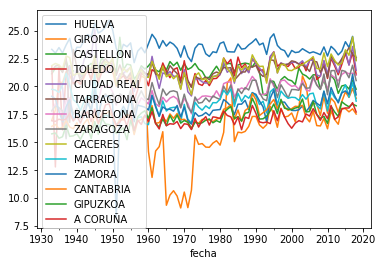

In [71]:
df_tmax_yearly.plot()
plt.show()